## Report No.05: Volterraモデルを以下の条件で計算してみよう
### 1. 漁業効果なしで、時間方向に対称なスキームを実装
時間微分項 $du/dt$を, 時間$t = (n+1/2)\Delta t$で差分$(u_{n+1}-u_n)/\Delta t$で近似し  
$u(t)$は時間方向の平均$(u_{n+1}+u_n)/2$で近似した。  
vの時間微分についての式も同様に近似した。  
求めるべき解は以下の関数が0になるになるようなベクトルである。 

In [1]:
function h(uv,uv_old)
    u,v = uv[1],uv[2]
    U,V = uv_old[1],uv_old[2]
    return [ (((-C1*((u+U)/2)*((v+V)/2))+D1*((u+U)/2))*Δt)+u-U,
             (((C2*((u+U)/2)*((v+V)/2))-D2*((v+V)/2))*Δt)+v-V]
end

h (generic function with 1 method)

次に初期値と係数を設定する。
以下のように指定した。

In [2]:
Δt = 0.05
C1 = C2 = D1 = D2 = 1.0
u0 = v0 = 0.7

uv_sq = [ u0 v0 ]
uv_old = [ u0, v0 ]

t_sq = Δt * [ 0:500 ]

1-element Array{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},1}:
 0.0:0.05:25.0

NLsolveパッケージを用いて関数hを以下のように解いた。  
解はその都度、配列に追加した。

In [3]:
using NLsolve

function nls(func, params...; ini = [0.0])
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

for n in 1:500
    uv = nls(h, uv_old, ini = uv_old)[1]
    uv_sq = vcat(uv_sq, [ uv[1] uv[2] ])
    uv_old = uv
end

時間tに対してuとvをそれぞれプロットすると以下のようになった。

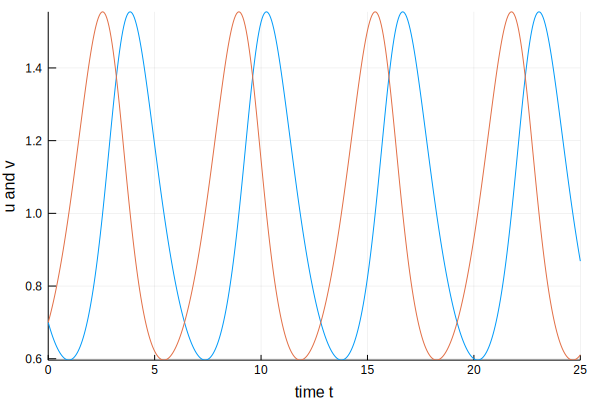

In [4]:
using Plots
gr()

plot(t_sq, uv_sq, xaxis = "time t", yaxis = "u and v", leg = false)

相図は以下のようになった。  
Eular法で解いたときとは異なり、周回してもきちんと初期値を通っているのが確認できた。

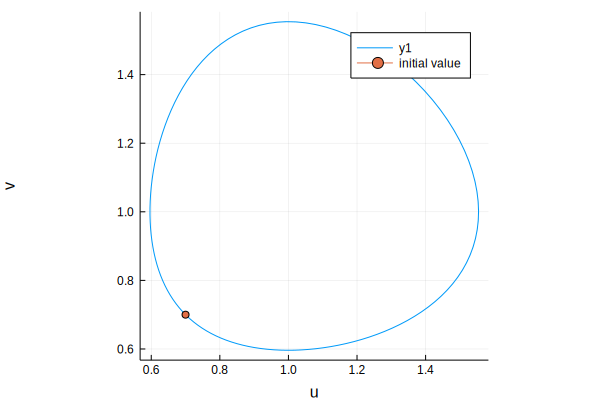

In [5]:
u_sq = uv_sq[:,1]
v_sq = uv_sq[:,2]

plot(u_sq, v_sq, aspect_ratio=1, xaxis = "u", yaxis = "v")
plot!((u0,v0), marker = :circle, lab = "initial value")

### 2. 漁業効果ありで、時間方向に対称なスキームを実装
次にVolterraモデルにおいて漁業効果を含めた場合の様子を見る。  
漁業の影響係数$E(>0)$ を用いて以下のように関数を定義しなおす。

In [6]:
function h_fishing(uv,uv_old)
    u,v = uv[1],uv[2]
    U,V = uv_old[1],uv_old[2]
    return [ (((-C1*((u+U)/2)*((v+V)/2))+D1*((u+U)/2)-E*((u+U)/2))*Δt)+u-U,
             (((C2*((u+U)/2)*((v+V)/2))-D2*((v+V)/2))*Δt-E*((v+V)/2)*Δt)+v-V]
end

h_fishing (generic function with 1 method)

先と同じように初期値と係数を設定する。  
係数Eは0.5とした。

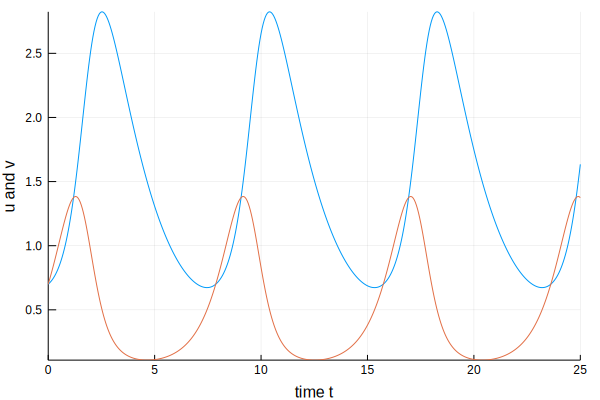

In [9]:
Δt = 0.05
C1 = C2 = D1 = D2 = 1.0
E = 0.5
u0 = v0 = 0.7

uv_f_sq = [ u0 v0 ]
uv_f_old = [ u0, v0 ]

t_sq = Δt * [ 0:500 ]

for n in 1:500
    uv_f = nls(h_fishing, uv_f_old, ini = uv_f_old)[1]
    uv_f_sq = vcat(uv_f_sq, [ uv_f[1] uv_f[2] ])
    uv_f_old = uv_f
end

plot(t_sq, uv_f_sq, xaxis = "time t", yaxis = "u and v", leg = false)


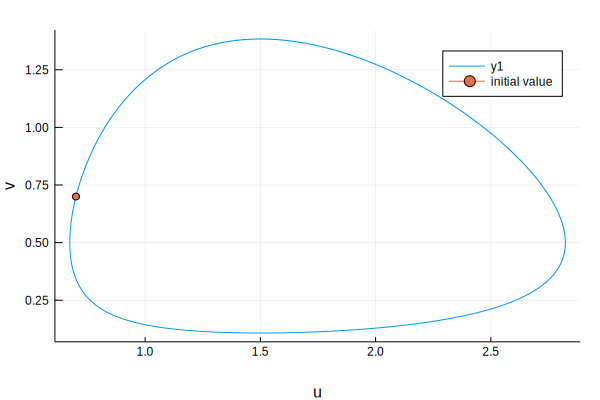

In [10]:
u_f_sq = uv_f_sq[:,1]
v_f_sq = uv_f_sq[:,2]

plot(u_f_sq, v_f_sq, aspect_ratio=1, xaxis = "u", yaxis = "v")
plot!((u0,v0), marker = :circle, lab = "initial value")

### 3. 漁業効果無しで、Runge-Kuttaスキームを実装

まず、以下のように連立微分方程式を定義した。

In [11]:
ru(u,v) = -C1*u*v +D1*u
rv(u,v) = C2*u*v -D2*v

rv (generic function with 1 method)

次いで、Runge-Kutta 法で 1ステップすすめる関数を定義した。  
変数uとvについてそれぞれ計算したものを次ステップの変数とし、  
2式について同時並行で計算を行っていく。

In [12]:
function RK(u,v)
    ru1 = ru(u,v)
    rv1 = rv(u,v)
    
    ru2 = ru(u + Δt/2 * ru1, v + Δt/2 * rv1)
    rv2 = rv(u + Δt/2 * ru1, v + Δt/2 * rv1)
    
    ru3 = ru(u + Δt/2 * ru2, v + Δt/2 * rv2)
    rv3 = rv(u + Δt/2 * ru2, v + Δt/2 * rv2)
    
    ru4 = ru(u + Δt * ru3, v + Δt * rv3)
    rv4 = rv(u + Δt * ru3, v + Δt * rv3)
    
    return u + Δt * (ru1 + 2*ru2 + 2*ru3 + ru4)/6, v + Δt * (rv1 + 2*rv2 + 2*rv3 + rv4)/6 
end

RK (generic function with 1 method)

初期値を設定し、先ほど作成したRK法の関数によって連立方程式を解いた。

In [13]:
Δt = 0.05
C1 = C2 = D1 = D2 = 1.0
u0 = v0 = 0.7

uv_rk_sq = [ u0 v0 ]

u, v = u0, v0

for n in 1:500
    u,v = RK(u,v)
    uv_rk_sq = vcat(uv_rk_sq, [ u v ])
end

解を時間についてプロットした。以下のようになった。

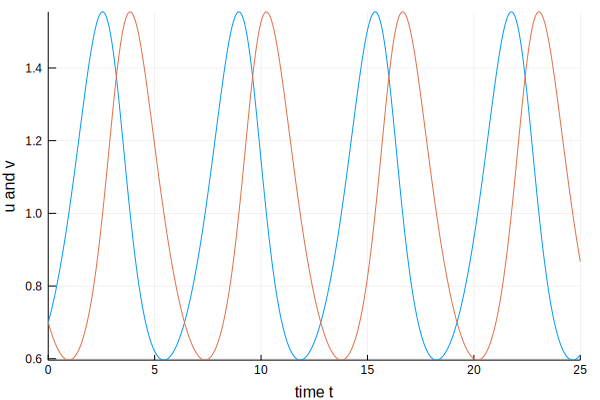

In [14]:
t_rk_sq = [ n*Δt for n in 0:500 ]
plot(t_rk_sq, uv_rk_sq, xaxis = "time t", yaxis = "u and v", leg = false)

相図をプロットした。以下のようになった。

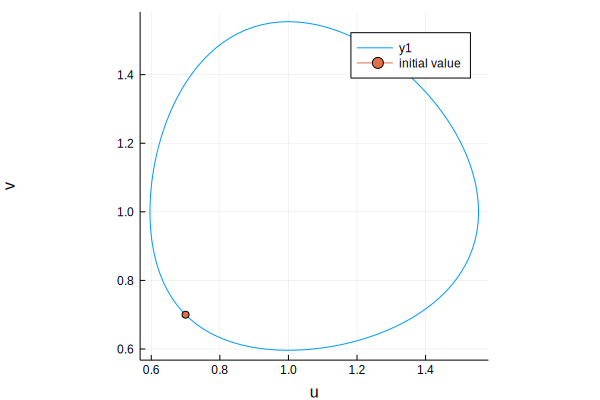

In [15]:
u_rk_sq = uv_rk_sq[:,1]
v_rk_sq = uv_rk_sq[:,2]

plot(u_rk_sq, v_rk_sq, aspect_ratio=1, xaxis = "u", yaxis = "v")
plot!((u0,v0), marker = :circle, lab = "initial value")

### 4. 漁業効果有りで、Runge-Kuttaスキームを実装

漁業効果を含めた連立微分方程式をRunge-kuttaスキームを用いて解く。  
漁業効果がある場合の連立微分方程式を以下のように定義した。

In [16]:
ru_fishing(u,v) = -C1*u*v +D1*u -E*u
rv_fishing(u,v) = C2*u*v -D2*v -E*v

rv_fishing (generic function with 1 method)

次に漁業効果がある場合のRunge-kuttaスキームを以下のように定義した。  
関数名を置き換えるという処理だけを加え、そのほかは先の関数のコピーとした。

In [17]:
function RK_f(u,v)
    ru(u,v) = ru_fishing(u,v)
    rv(u,v) = rv_fishing(u,v)
    
    ru1 = ru(u,v)
    rv1 = rv(u,v)
    
    ru2 = ru(u + Δt/2 * ru1, v + Δt/2 * rv1)
    rv2 = rv(u + Δt/2 * ru1, v + Δt/2 * rv1)
    
    ru3 = ru(u + Δt/2 * ru2, v + Δt/2 * rv2)
    rv3 = rv(u + Δt/2 * ru2, v + Δt/2 * rv2)
    
    ru4 = ru(u + Δt * ru3, v + Δt * rv3)
    rv4 = rv(u + Δt * ru3, v + Δt * rv3)
    
    return u + Δt * (ru1 + 2*ru2 + 2*ru3 + ru4)/6, v + Δt * (rv1 + 2*rv2 + 2*rv3 + rv4)/6 
end

RK_f (generic function with 1 method)

初期値を設定し、関数を実行して、結果を時間に対してプロットした。

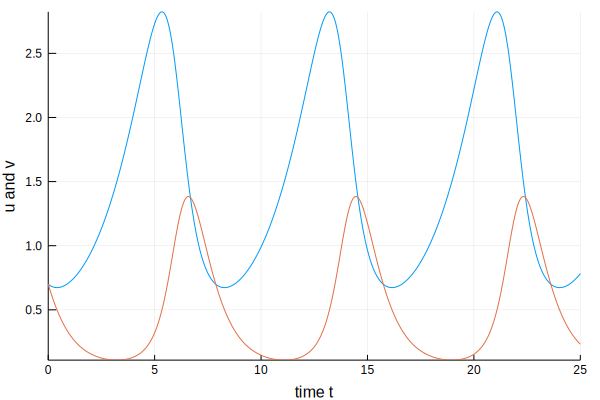

In [18]:
Δt = 0.05
C1 = C2 = D1 = D2 = 1.0
u0 = v0 = 0.7

uv_rkf_sq = [ u0 v0 ]

u, v = u0, v0

for n in 1:500
    u,v = RK_f(u,v)
    uv_rkf_sq = vcat(uv_rkf_sq, [ u v ])
end

t_rkf_sq = [ n*Δt for n in 0:500 ]
plot(t_rkf_sq, uv_rkf_sq, xaxis = "time t", yaxis = "u and v", leg = false)

相図は以下のようになった。

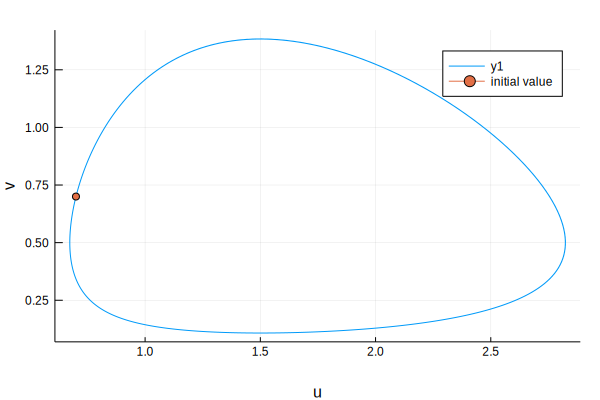

In [19]:
u_rkf_sq = uv_rkf_sq[:,1]
v_rkf_sq = uv_rkf_sq[:,2]

plot(u_rkf_sq, v_rkf_sq, aspect_ratio=1, xaxis = "u", yaxis = "v")
plot!((u0,v0), marker = :circle, lab = "initial value")

時間方向に対称なスキームでは、1ステップ進めるための関数を生成する際に変数に対して既知量と未知量を用いて近似した微分方程式を入力しなければならないのに対し、  
Runge-Kuttaスキームでは微分方程式をそのまま定義して関数を適用するだけでいいので用いることが容易であった。
時間方向に対称なスキームとRunge-Kuttaスキームを用いたそれぞれの結果を重ねてプロットすると以下のようになった。  
この結果から精度はほとんど同じであるといえる。

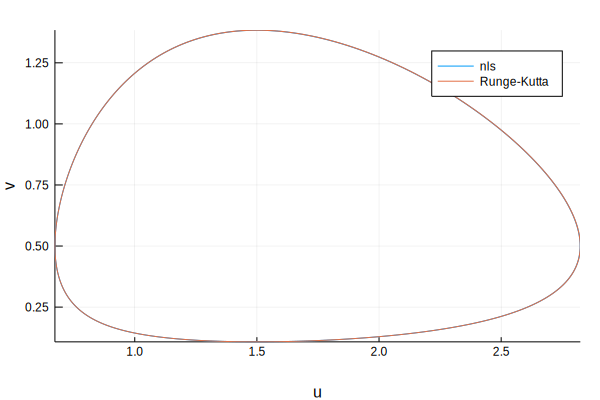

In [20]:
plot(u_f_sq, v_f_sq, aspect_ratio=1, xaxis = "u", yaxis = "v", lab = "nls")
plot!(u_rkf_sq, v_rkf_sq, aspect_ratio=1, lab = "Runge-Kutta")

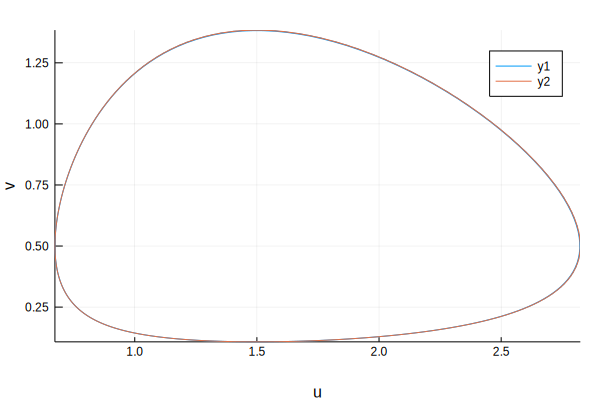

In [21]:
Δt = 0.1

uv_rkf_sq2 = [ u0 v0 ]

u, v = u0, v0

for n in 1:250
    u,v = RK_f(u,v)
    uv_rkf_sq2 = vcat(uv_rkf_sq2, [ u v ])
end

t_rkf_sq2 = [ n*Δt for n in 0:250 ]

u_rkf_sq2 = uv_rkf_sq2[:,1]
v_rkf_sq2 = uv_rkf_sq2[:,2]
plot(u_rkf_sq2, v_rkf_sq2, aspect_ratio=1, xaxis = "u", yaxis = "v")
plot!(u_rkf_sq, v_rkf_sq, aspect_ratio=1)